In [10]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import os.path as path
import numpy as np
import random as rd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import L2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare dataset
Dataset can be found at [kaggle](https://www.kaggle.com/datasets/datamunge/sign-language-mnist) \
Because files do not persist between sessions, I have to download from Google Drive \

In [11]:
# perform downloading datasets each session
def download_file_from_google_drive(id, destination):
  URL = "https://docs.google.com/uc?export=download"

  session = requests.Session()

  response = session.get(URL, params = { 'id' : id }, stream = True)
  token = get_confirm_token(response)

  if token:
    params = { 'id' : id, 'confirm' : token }
    response = session.get(URL, params = params, stream = True)

  save_response_content(response, destination)

def get_confirm_token(response):
  for key, value in response.cookies.items():
    if key.startswith('download_warning'):
      return value

  return None

def save_response_content(response, destination):
  CHUNK_SIZE = 32768

  with open(destination, "wb") as f:
    for chunk in response.iter_content(CHUNK_SIZE):
      if chunk: # filter out keep-alive new chunks
        f.write(chunk)


if not path.exists("sign_mnist_train.csv"):
  train_csv_id = "15yEkH1L6N0f8ijo6V3IY3QMxuv3Xmiz-"
  download_file_from_google_drive(train_csv_id, "./sign_mnist_train.csv")
if not path.exists("sign_mnist_test.csv"):
  test_csv_id = "1EcMiEgPi7cL1UTha6MEQY_RPUrxIsahh"
  download_file_from_google_drive(test_csv_id, "./sign_mnist_test.csv")

Hyperparameters

In [12]:
VALIDATION_RATIO = 0.2
BATCH_SIZE = 128
EPOCHS = 200
NUM_CLASSES = 26
DROPOUT_RATE = 0.4

Prepare data

In [13]:
TRAIN_DATA_PATH = "sign_mnist_train.csv"
TEST_DATA_PATH = "sign_mnist_test.csv"

train_data = pd.read_csv(TRAIN_DATA_PATH)
test_data = pd.read_csv(TEST_DATA_PATH)

label_train = train_data["label"]
X_train = train_data.drop("label", axis=1)
X_train = np.array(X_train).reshape(-1, 28, 28, 1)
y_train = keras.utils.to_categorical(label_train, NUM_CLASSES)

image_gen = ImageDataGenerator(
  rescale=1./255, #easier for network to interpret numbers in range [0,1]
  zoom_range=0.1,
  width_shift_range=0.1,
  height_shift_range=0.1,
  rotation_range=10,
  validation_split=VALIDATION_RATIO
)

train_generator = image_gen.flow(
  X_train,
  y_train,
  batch_size=BATCH_SIZE,
  shuffle=True,
  subset='training',
  seed=42
)

valid_generator = image_gen.flow(
  X_train,
  y_train,
  batch_size=BATCH_SIZE,
  shuffle=True,
  subset='validation',
)

label_test = test_data["label"]
X_test = test_data.drop("label", axis=1)

X_test = np.array(X_test).reshape(-1, 28, 28, 1)
X_test = X_test / 255
y_test = keras.utils.to_categorical(label_test, NUM_CLASSES)

### Plot several samples

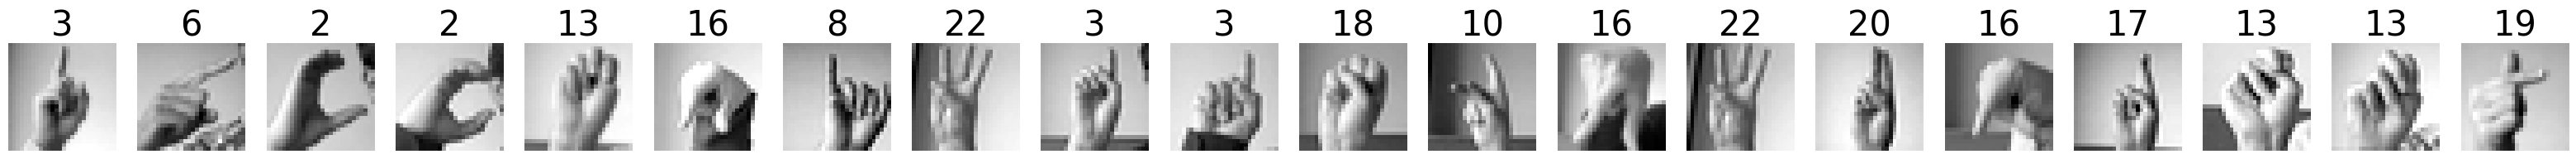

In [14]:
# plot data
plt.figure(figsize=(40,40))

num_images = 20
for i in range(num_images):
  row = X_train[i]
  label = label_train[i]

  plt.subplot(1, num_images, i+1)
  plt.title(f"{label}", fontdict={'fontsize': 30})
  plt.axis('off')
  plt.imshow(row, cmap='gray')

# Data normalization

# Model Configuration

In [15]:
cnn_model = keras.Sequential([
    layers.Conv2D(6, (5, 5), padding='same', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.ReLU(),
    layers.Conv2D(16, (5, 5), padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.ReLU(),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=L2()),
    layers.Dense(64, activation='relu', kernel_regularizer=L2()),
    layers.Dropout(0.2),
    layers.Dense(26, activation='softmax')
])

cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 6)           │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 112,998 (441.40 KB)

 Trainable params: 112,998 (441.40 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
cnn_model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_generator,
    callbacks=[EarlyStopping(patience=5, monitor='loss')]
  )
loss, acc = cnn_model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {acc}")
cnn_model.save("cnn_model.keras")

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.0616 - loss: 4.5521 - val_accuracy: 0.2896 - val_loss: 2.6151
Epoch 2/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.2862 - loss: 2.4829 - val_accuracy: 0.4990 - val_loss: 1.8963
Epoch 3/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.4406 - loss: 1.9614 - val_accuracy: 0.5296 - val_loss: 1.7172
Epoch 4/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5175 - loss: 1.7177 - val_accuracy: 0.6445 - val_loss: 1.4074
Epoch 5/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - accuracy: 0.5843 - loss: 1.5347 - val_accuracy: 0.6647 - val_loss: 1.2872
Epoch 6/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.6334 - loss: 1.3857 - val_accuracy: 0.6687 - val_loss: 1.2526
Epoch 7/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.6640 - loss: 1.2897 - val_accuracy: 0.7465 - val_loss: 1.0737
Epoch 8/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.6955 - loss: 1.1983 - val_a

# CNN Architecture for MNIST
https://www.kaggle.com/code/cdeotte/how-to-choose-cnn-architecture-mnist

In [17]:
cnn2 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (5, 5), strides=2, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(DROPOUT_RATE),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (5, 5), strides=2, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(DROPOUT_RATE),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(DROPOUT_RATE),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

cnn2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
cnn2.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_generator,
    callbacks=[EarlyStopping(patience=5, monitor='loss')]
  )
loss, acc = cnn2.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {acc}")
cnn2.save("cnn2_model.keras")

Epoch 1/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - accuracy: 0.2319 - loss: 2.9318 - val_accuracy: 0.0503 - val_loss: 4.8683
Epoch 2/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.6690 - loss: 0.9977 - val_accuracy: 0.0428 - val_loss: 6.5163
Epoch 3/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.8477 - loss: 0.4787 - val_accuracy: 0.5374 - val_loss: 1.4461
Epoch 4/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.9096 - loss: 0.2886 - val_accuracy: 0.9587 - val_loss: 0.1361
Epoch 5/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.9506 - loss: 0.1681 - val_accuracy: 0.8614 - val_loss: 0.4682
Epoch 6/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.9646 - loss: 0.1216 - val_accuracy: 0.9882 - val_loss: 0.0384
Epoch 7/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9781 - loss: 0.0798 - val_accuracy: 0.9534 - val_loss: 0.1285
Epoch 8/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.9798 - loss: 

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


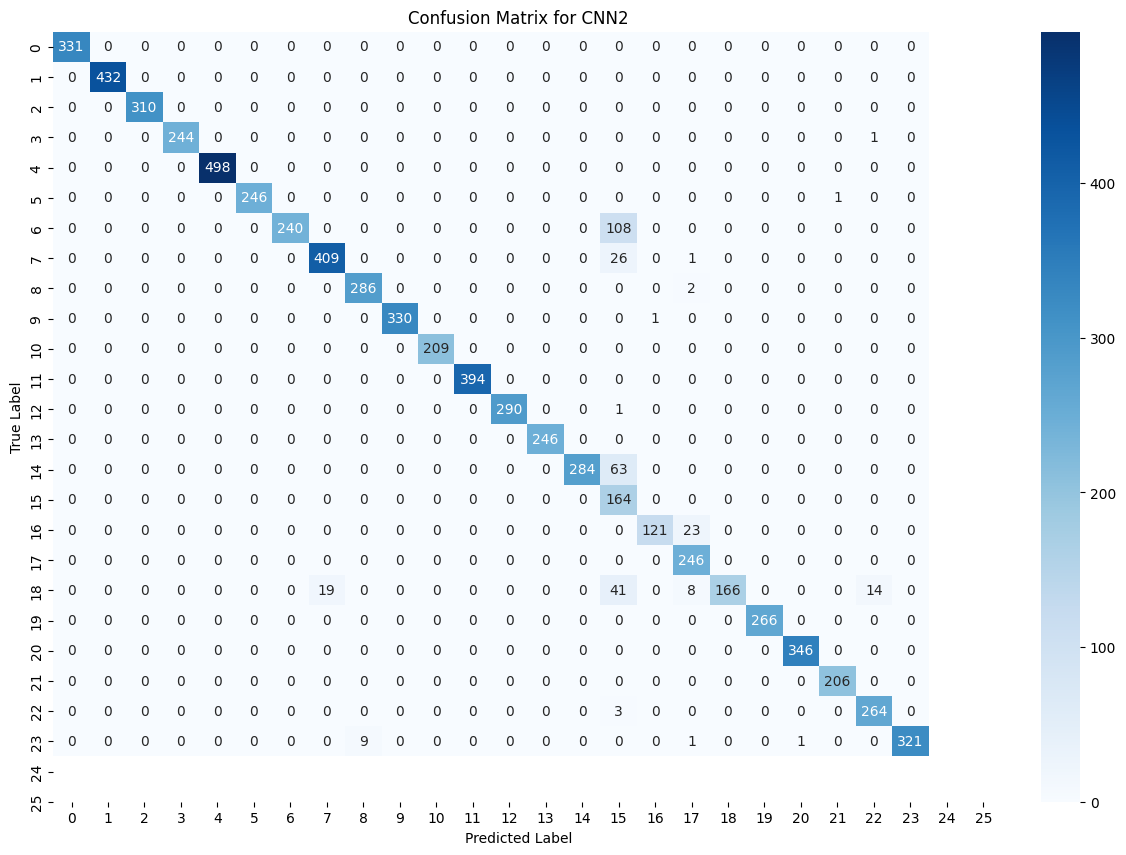

In [18]:
# Predict the labels for the test data using the cnn2 model
y_pred = cnn2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for CNN2')
plt.show()